This notebook munges the AUC values for the Tumor vs. Normal prediction task and makes several visualizations.

In [1]:
import getpass
import os
import sys
import time

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

cthoyt


In [5]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [6]:
print(time.asctime())

Wed May 29 17:36:38 2019


In [7]:
df = pd.read_csv('../../input/tumor_prediction_results.tsv', sep='\t')
df = df.sort_values(['Database', 'Dataset'])
df.head()

,Database,Dataset,AUC
40,KEGG,BRCA,0.990240
41,KEGG,BRCA,0.993994
42,KEGG,BRCA,1.000000
43,KEGG,BRCA,1.000000
44,KEGG,BRCA,0.995041


Test whether on average all databases perform equally

In [8]:
formula = 'AUC ~ Database*Dataset'
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                    sum_sq     df          F        PR(>F)
Database          0.005490    3.0   1.461001  2.277233e-01
Dataset           0.179922    3.0  47.883358  1.582712e-21
Database:Dataset  0.010595    9.0   0.939891  4.926817e-01
Residual          0.180360  144.0        NaN           NaN


Compare MPath with the rest using Tukey’s multi-comparison method

In [9]:
# Set up the data for comparison (creates a specialised object)
for dataset, df_dataset in df.groupby('Dataset'):
    
    MultiComp = MultiComparison(
        df_dataset['AUC'],
        df_dataset['Database'],
    )
    print(f"{dataset}\n----")
    print(MultiComp.tukeyhsd().summary())

BRCA
----
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
 group1     group2    meandiff  lower   upper  reject
-----------------------------------------------------
  KEGG      MPath      0.0035   -0.005  0.012  False 
  KEGG     Reactome    0.0016  -0.0069  0.0101 False 
  KEGG   WikiPathways -0.0147  -0.0233 -0.0062  True 
 MPath     Reactome   -0.0019  -0.0104  0.0066 False 
 MPath   WikiPathways -0.0182  -0.0268 -0.0097  True 
Reactome WikiPathways -0.0163  -0.0249 -0.0078  True 
-----------------------------------------------------
KIRC
----
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
 group1     group2    meandiff  lower  upper  reject
----------------------------------------------------
  KEGG      MPath     -0.0056  -0.0443 0.0331 False 
  KEGG     Reactome   -0.0049  -0.0436 0.0338 False 
  KEGG   WikiPathways -0.0076  -0.0463 0.0311 False 
 MPath     Reactome    0.0007   -0.038 0.0394 False 
 MPath   WikiPathways -0.0021  -0.0408 0.0366 False 
Reactome WikiPat

Plot AUCs for each Database/Dataset

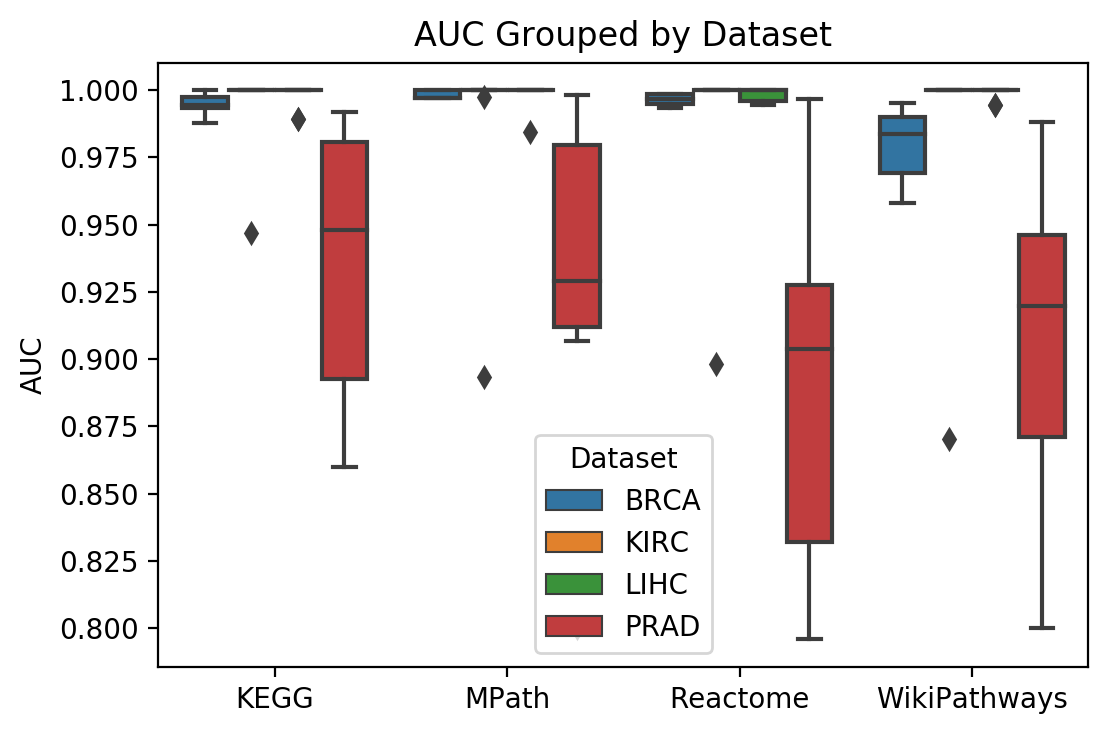

In [10]:
sns.boxplot(
    y='AUC',
    x='Database',
    hue='Dataset',
    data=df,
)
plt.xlabel('')
plt.title('AUC Grouped by Dataset')
plt.show()

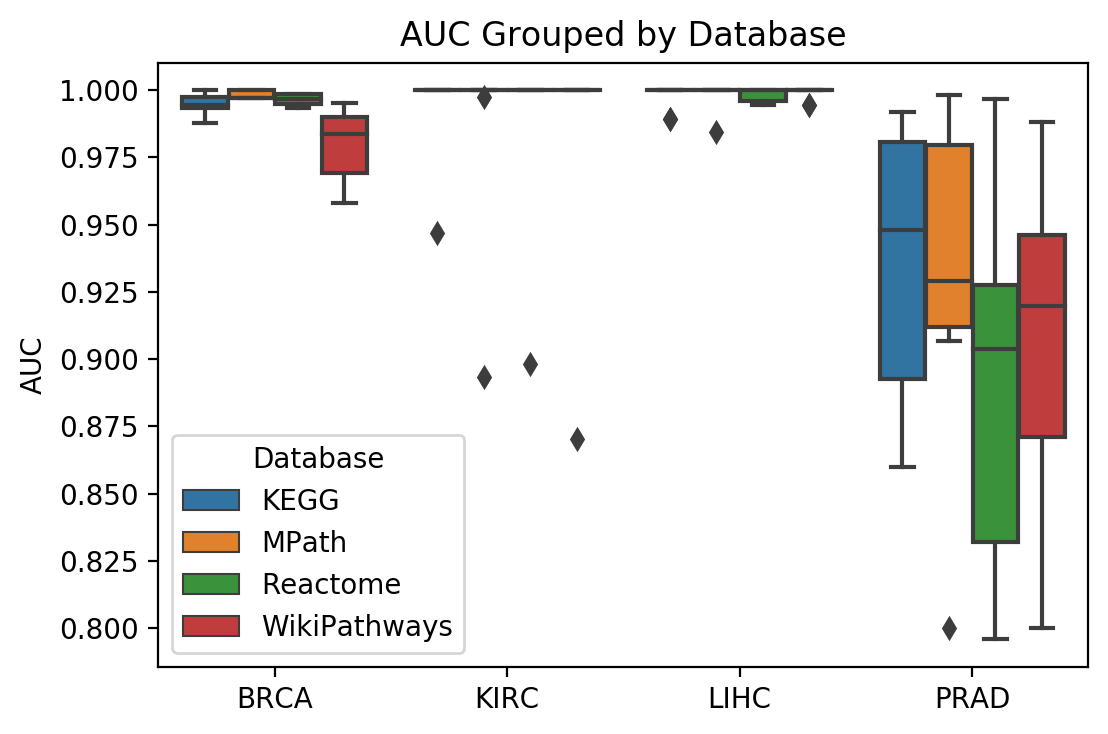

In [11]:
sns.boxplot(
    y='AUC',
    x='Dataset',
    hue='Database',
    data=df,
)
plt.xlabel('')
plt.title('AUC Grouped by Database')
plt.show()

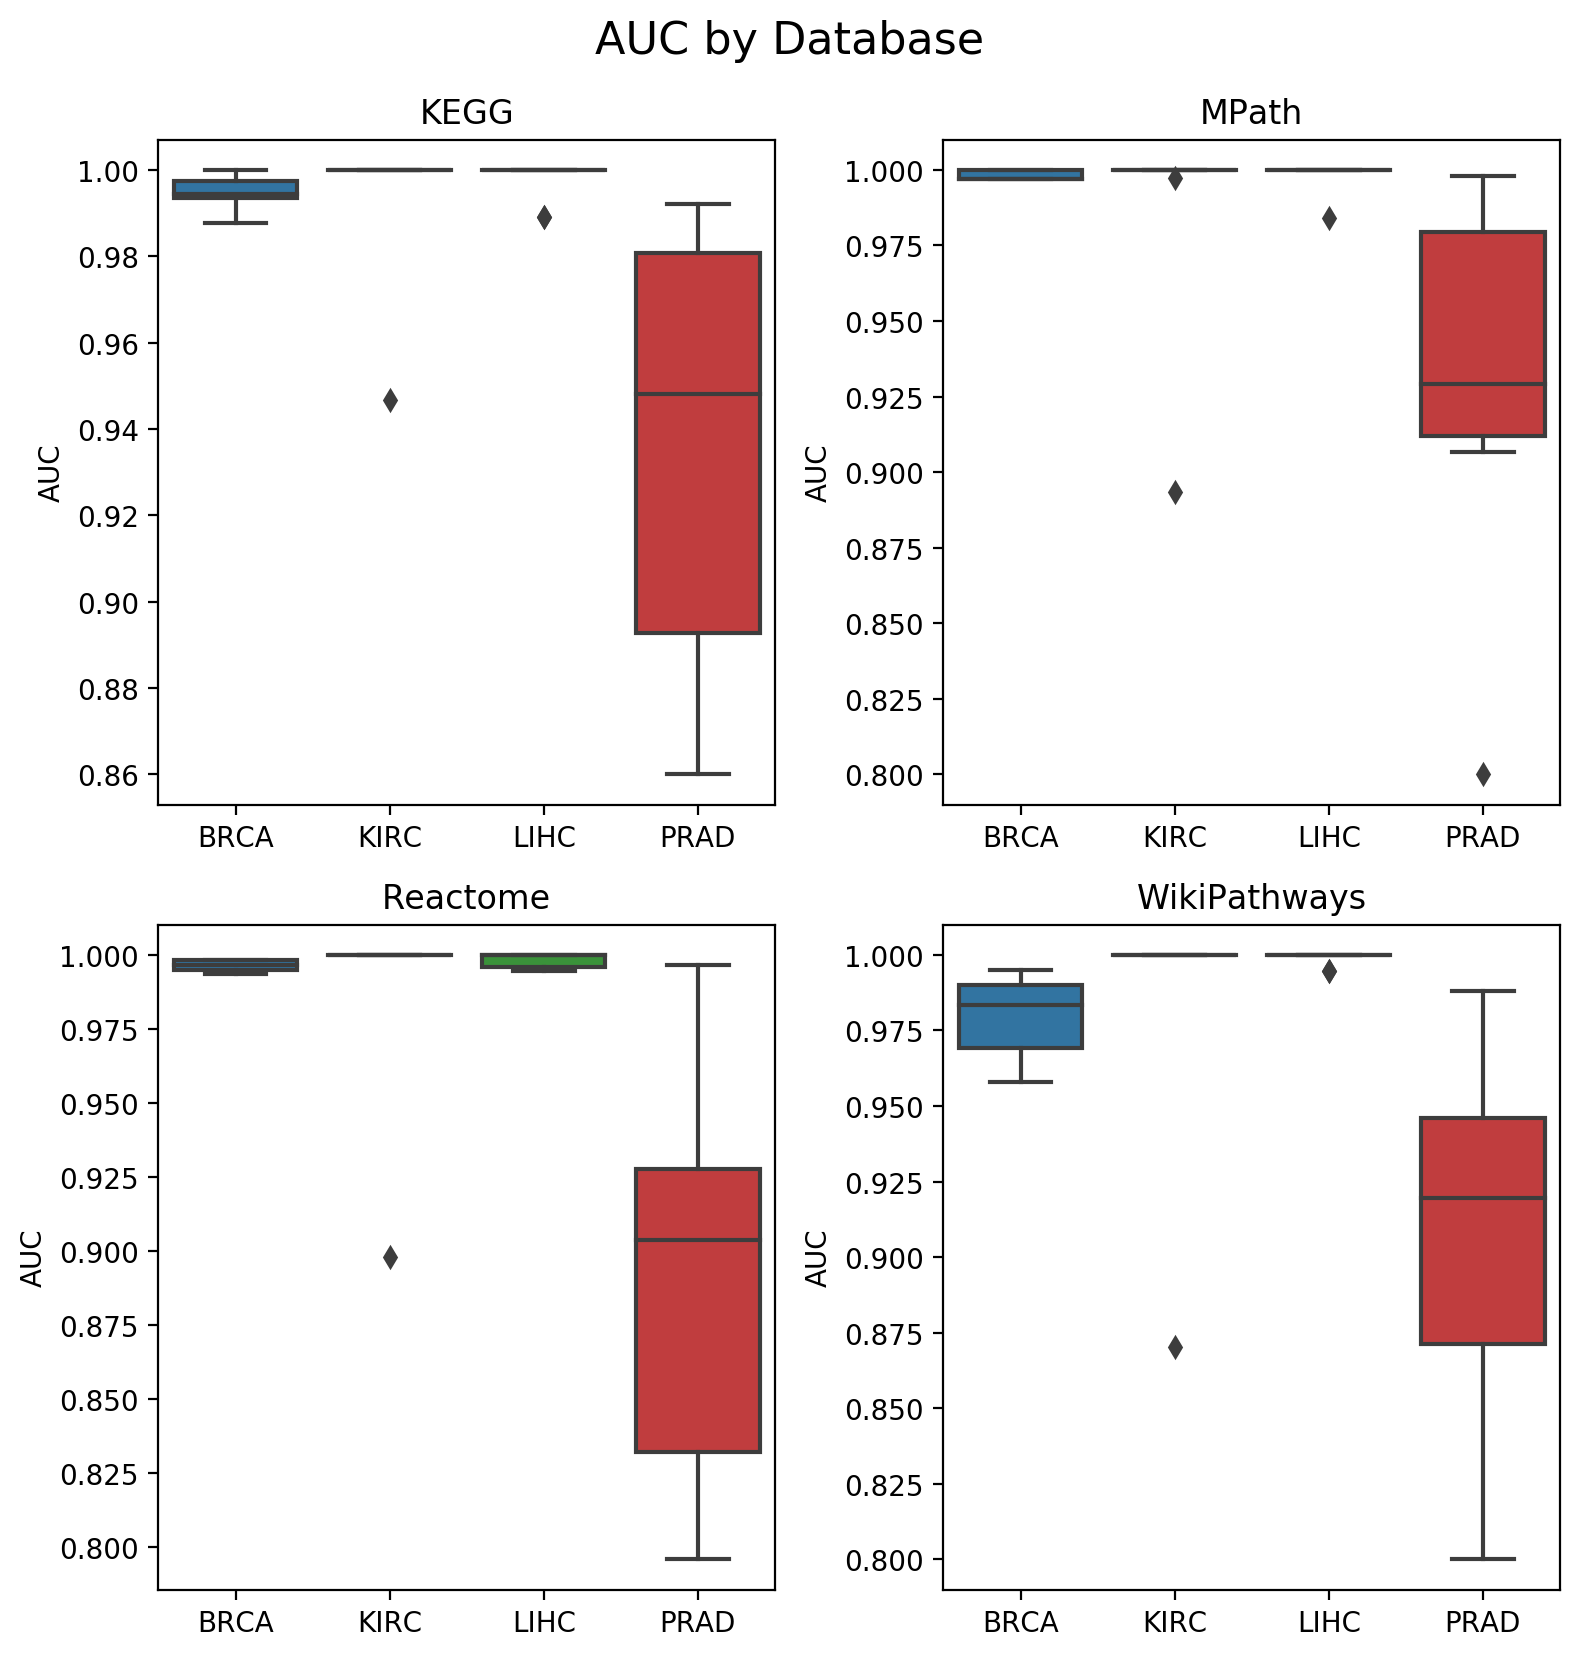

In [12]:
ncols = 2
nrows = df['Database'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

plt.suptitle('AUC by Database', fontsize=16, y=1.03)

y_min = df['AUC'].min()

for database, ax in zip(df['Database'].unique(), axes.ravel()):
    ax.set_title(database)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='AUC',
        x='Dataset',
        data=df[df['Database'] == database],
        ax=ax,
    )
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

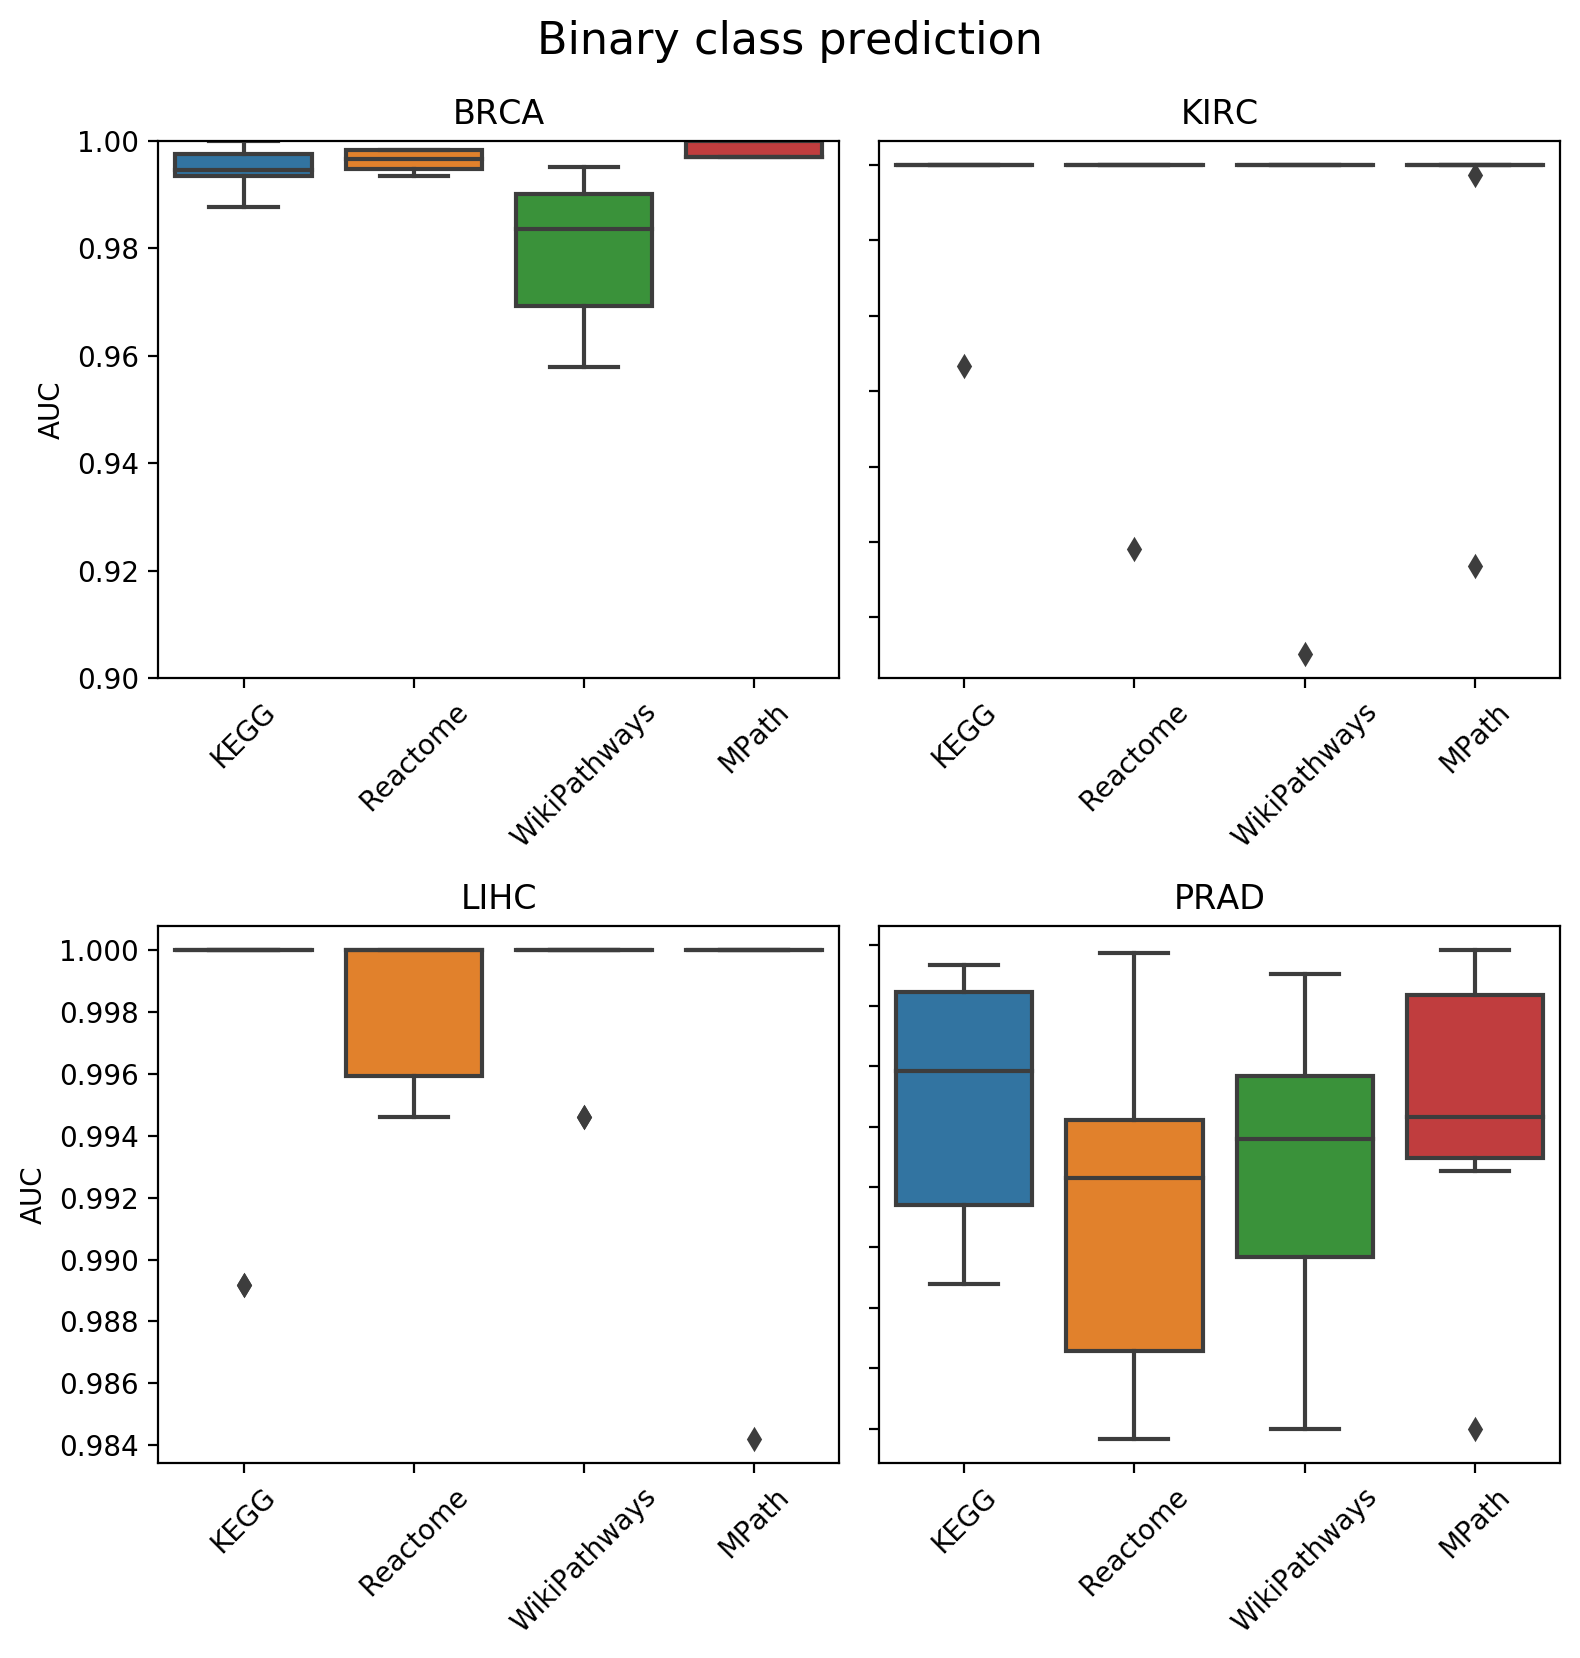

In [13]:
ncols = 2
nrows = df['Dataset'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

suptitle = plt.suptitle('Binary class prediction', fontsize=16, y=1.03)

for plot_num, (dataset, ax) in enumerate(zip(df['Dataset'].unique(), axes.ravel())):
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    if dataset == 'BRCA':
        ax.set_ylim(bottom=0.9, top=1.0)  
    sns.boxplot(
        y='AUC',
        x='Database',
        data=df[df['Dataset'] == dataset],
        order=['KEGG', 'Reactome', 'WikiPathways', 'MPath'],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Hide x label in all plots and leave y axis label for the leftmost plots
    ax.set_xlabel('')
    if plot_num in {1,3}:
        ax.set_ylabel('')
        ax.tick_params(labelleft=False) 

plt.tight_layout()
plt.savefig(
    os.path.join(os.path.expanduser('~'), 'Desktop', 'classification.png'),
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()